# UMAP on wavelet transforms

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import pandas as pd

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
from sklearn.cluster import KMeans
import umap
from sklearn.decomposition import PCA

functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood

one = ONE(mode='remote')

## Parameters

In [2]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_train_batches = 5

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], [
    '1.0', '2.0', '4.0', '8.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 5]
idx_end_list = [1, 2, 3, 9]

var_interest = 'wavelet'


# Sessions with cross-validated results

In [3]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    if not os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


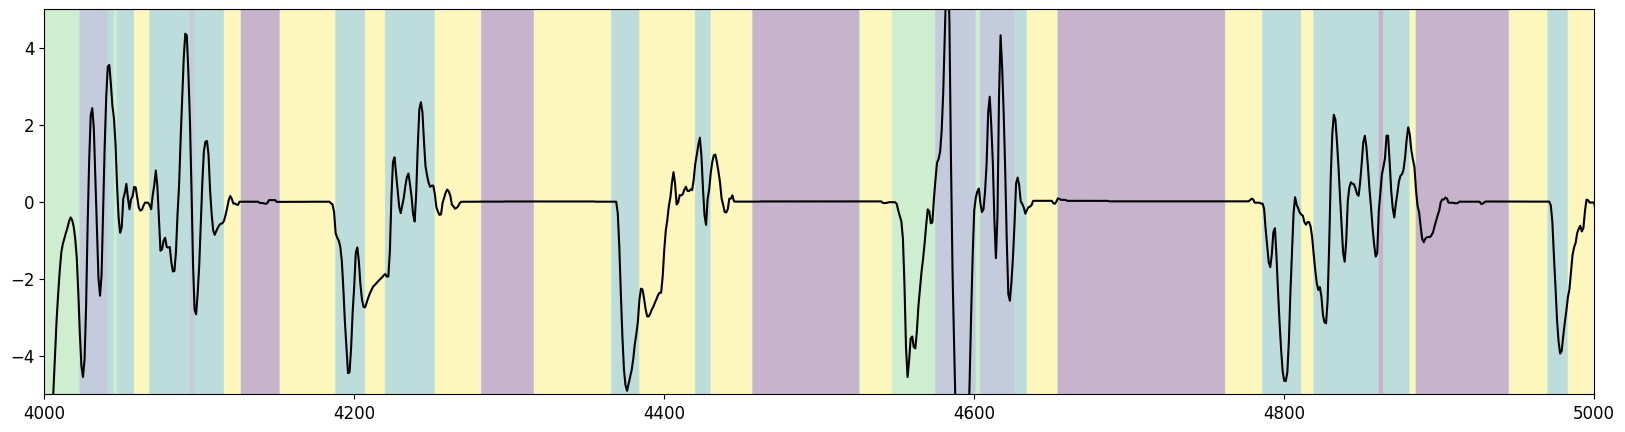

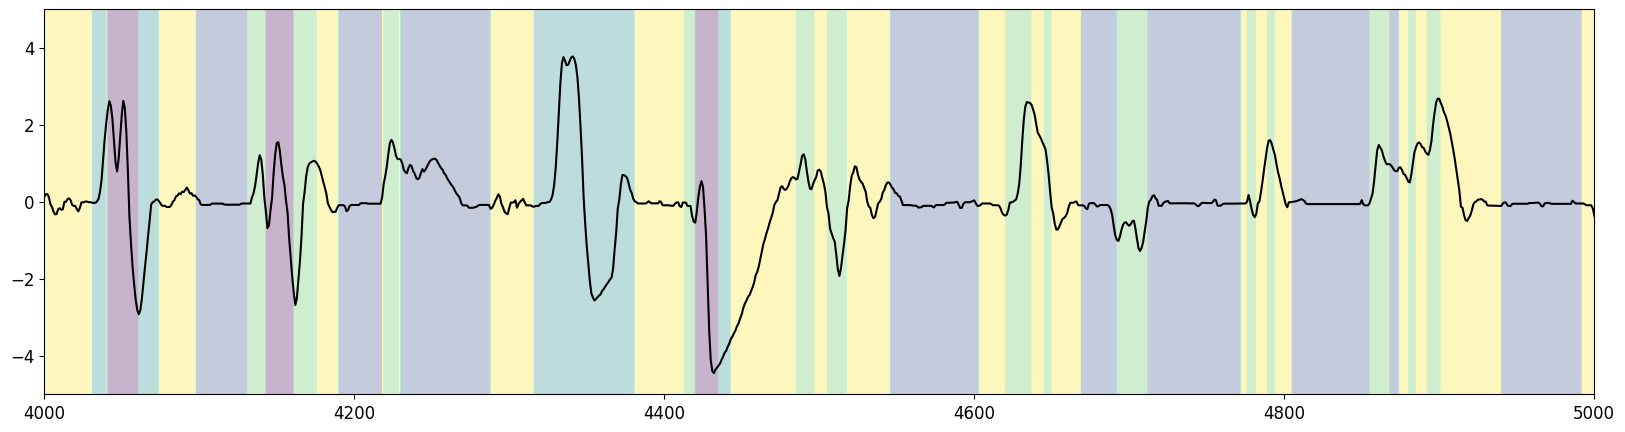

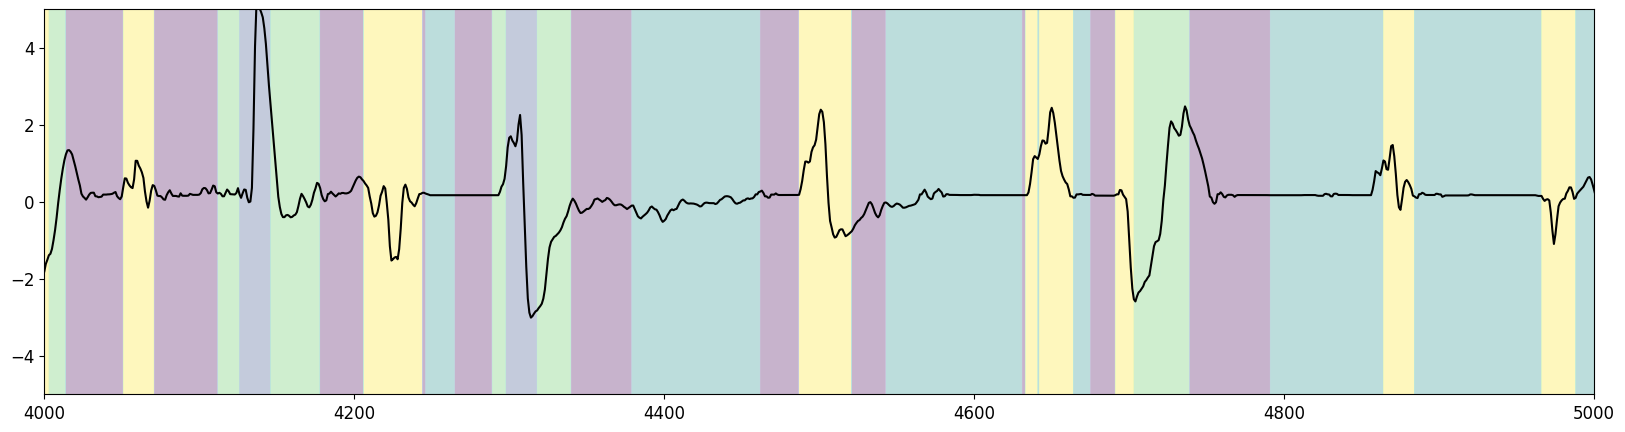

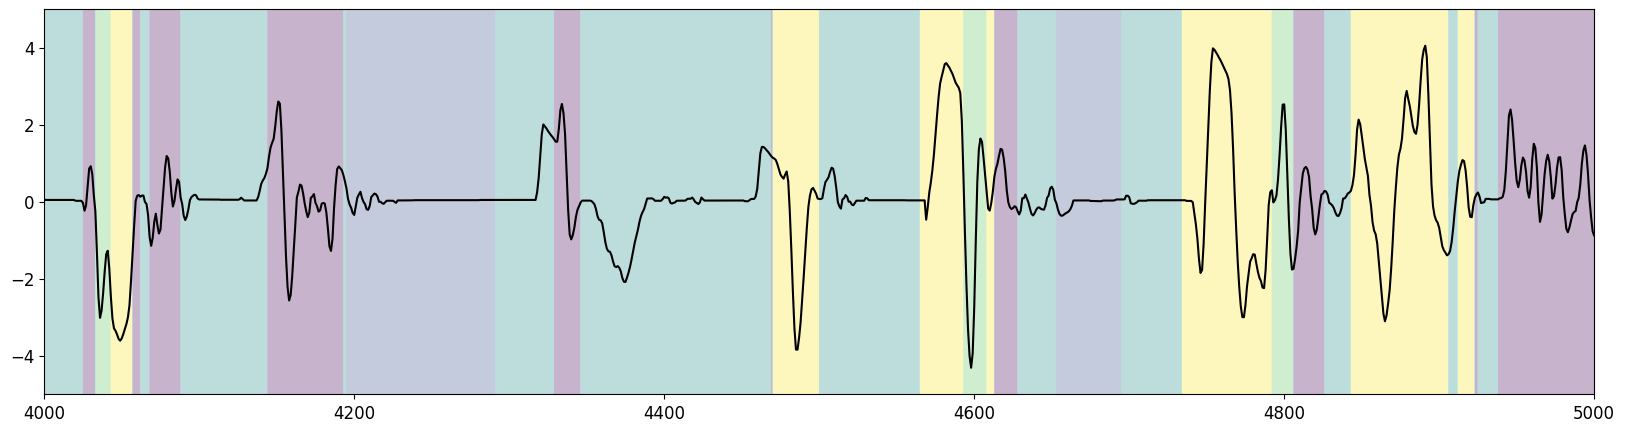

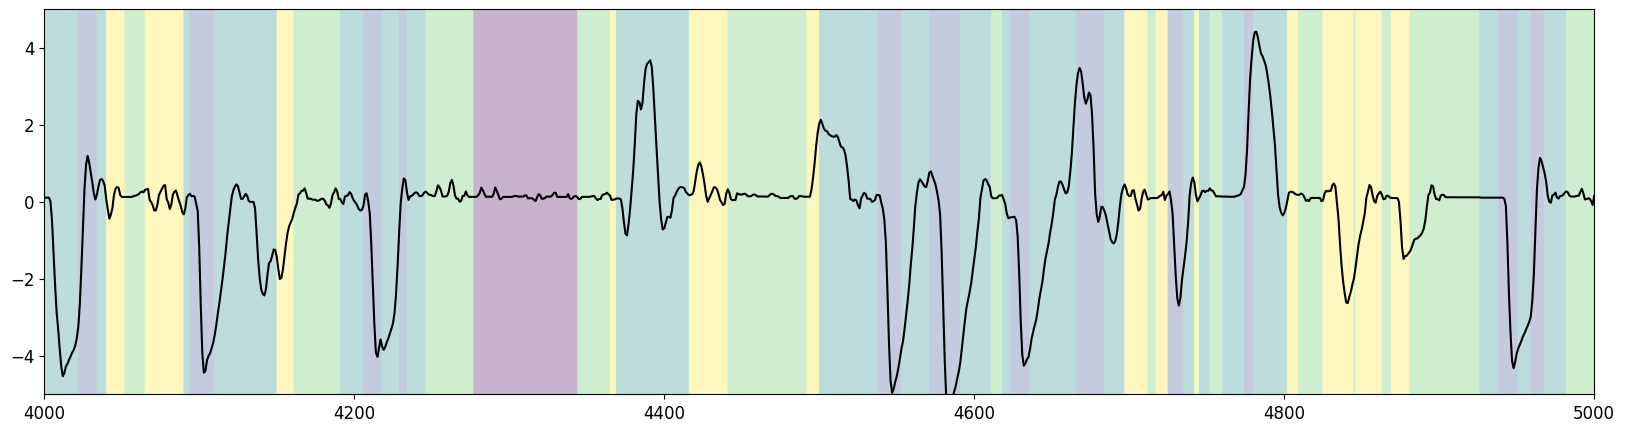

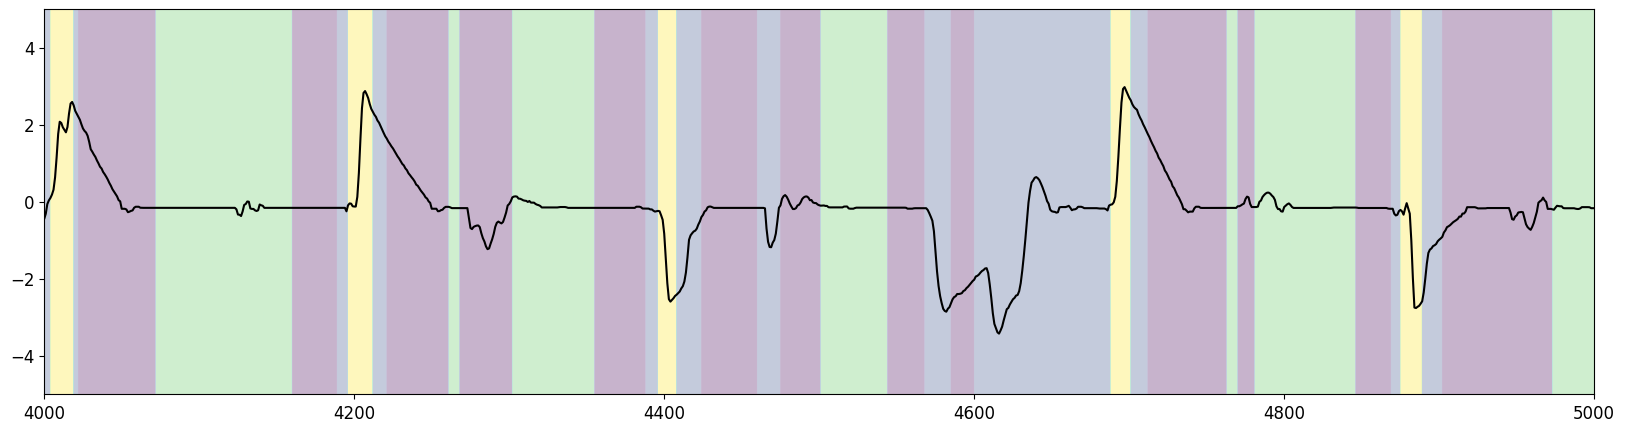

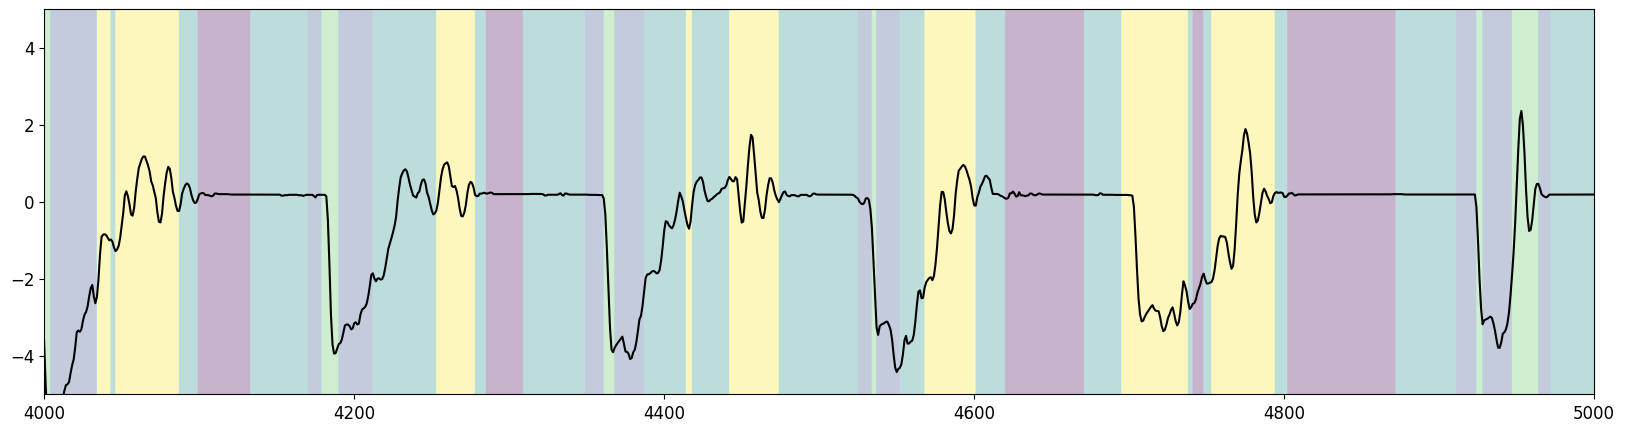

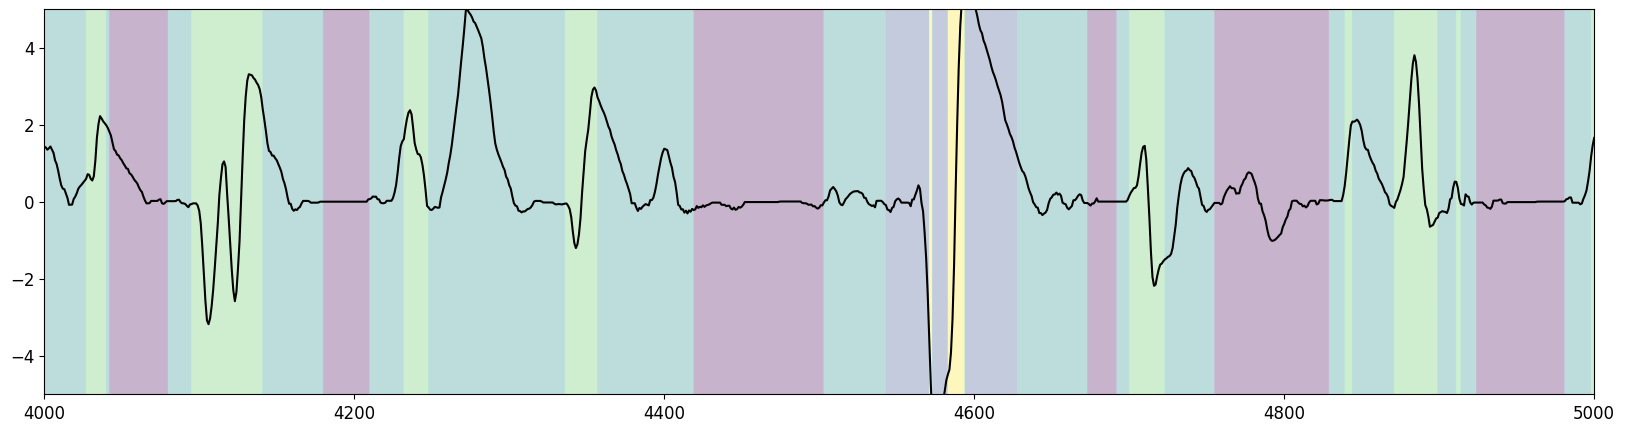

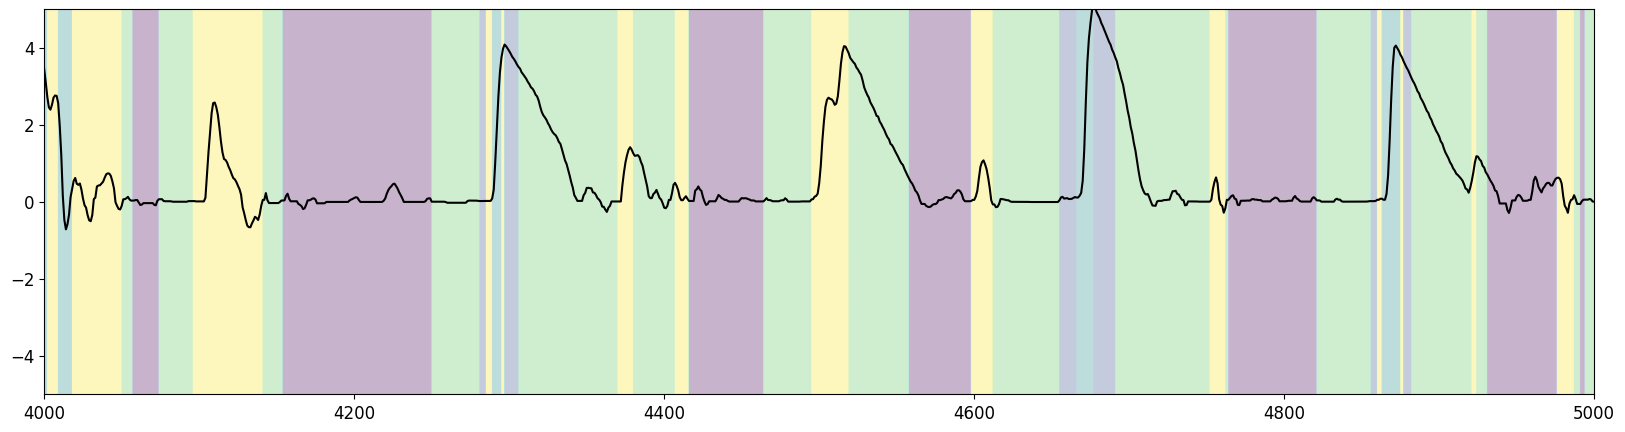

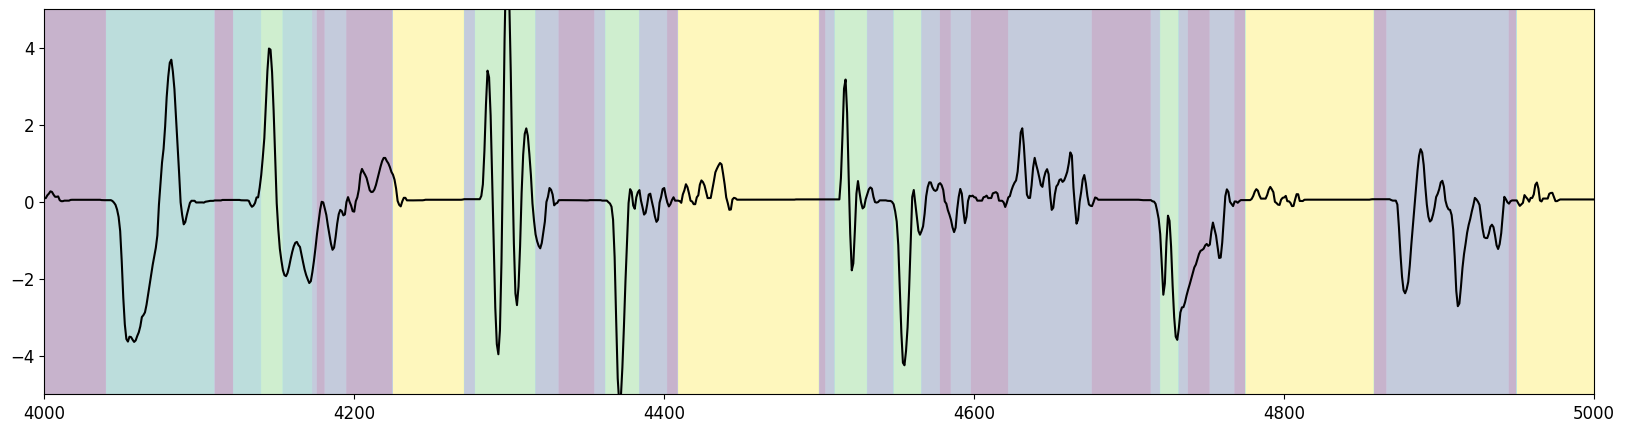

In [36]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(sessions_to_process[:10]):

    mouse_name = mat[0]
    session = mat[1]

    fit_id = str(mouse_name+session)

    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get standardized design_matrix
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]

    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    # data = np.array(unnorm_design_matrix[var_names])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)

    # repeats = 1
    # components = np.array([1, 3, 5, 7, 9, 11])
    # LLs = np.zeros((repeats, len(components))) * np.nan
    # for r in range(repeats):

    #     # Compute log likelihood of a GMM model with different components
    #     LLs[r, :] = GMM_neg_log_likelihood(data.copy(), components)

    # plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
    # plt.xlabel('Number of GMM components')
    # plt.ylabel('Negative log likelihood (SEM)')
    # plt.show()
    # # plt.savefig(file_path+'NLL_mice.svg', format="svg")

In [12]:
X = data.copy()

## PCA for dimensionality reduction

In [101]:
np.shape(X)

(281680, 5)

In [106]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Explained variance
explained_variance = pca.explained_variance_ 
total_explained_variance = explained_variance.sum()
ratio_explained_var = explained_variance / total_explained_variance

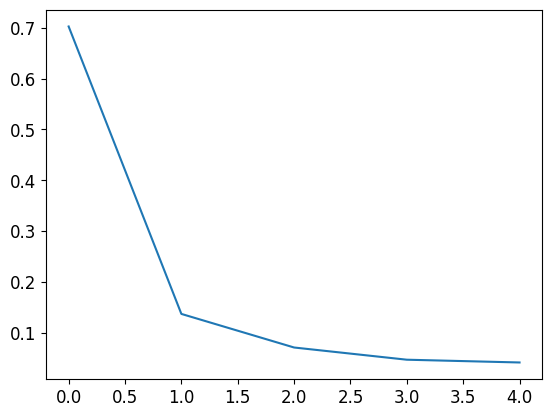

In [107]:
plt.plot(ratio_explained_var)

## UMAP

In [40]:

X = data.copy()
reducer = umap.UMAP(random_state= 42, n_components=5)
# reducer = umap.UMAP(n_components=2)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)

# embedding = reducer.fit_transform(standardized_X)
# embedding.shape

embedding = reducer.fit_transform(X)
embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(281680, 5)

In [108]:
repeats = 1
components = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

Text(0, 0.5, 'Negative log likelihood (SEM)')

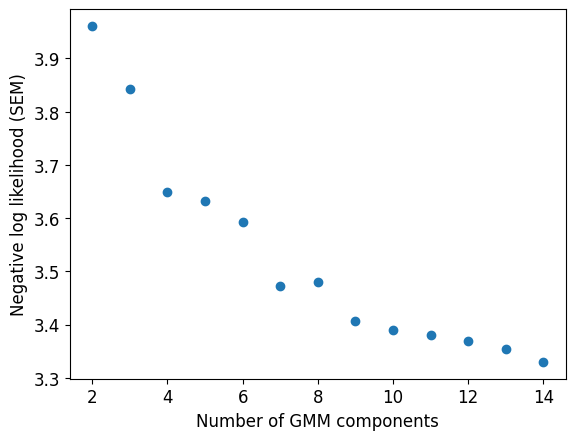

In [109]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    # reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration
    # # reducer = umap.UMAP(random_state= 42, n_components=2)

    # # Standardization using StandardScaler
    # scaler = StandardScaler()
    # standardized_X = scaler.fit_transform(X)

    # # embedding = reducer.fit_transform(standardized_X)
    # # embedding.shape

    # mouse_embedding = reducer.fit_transform(X)
    # mouse_embedding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_log_likelihood(embedding, components)
    
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")


Text(0, 0.5, 'UMAP 2')

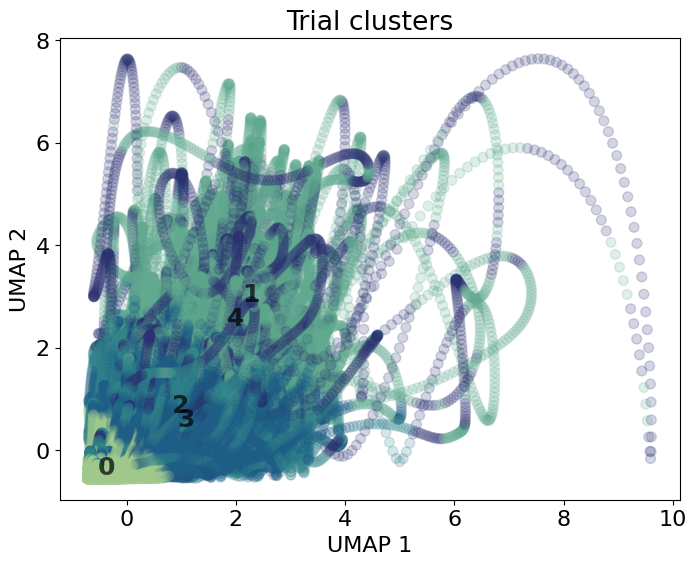

In [57]:
# Step 2: Perform KMeans Clustering
data_2d = embedding.copy()
data_2d = X.copy()
kmeans = KMeans(n_clusters=5, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans, s=50, alpha=0.2, cmap=sns.color_palette("crest", as_cmap=True)) # , cmap='Set2'

# Plot the centroids
centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')


plt.title("Trial clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")


(array([101786.,      0.,      0.,      0.,      0., 118145.,      0.,
             0.,      0.,  61749.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

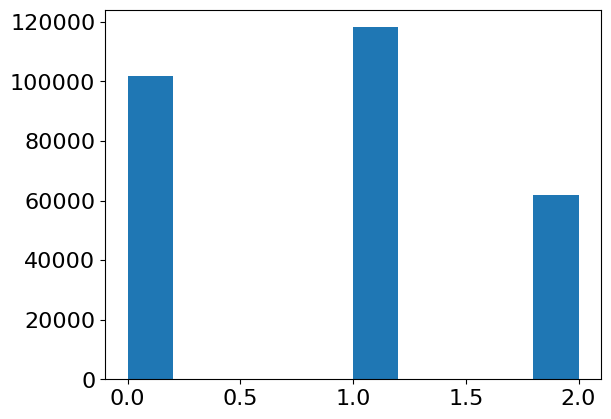

In [49]:
plt.hist(y_kmeans)

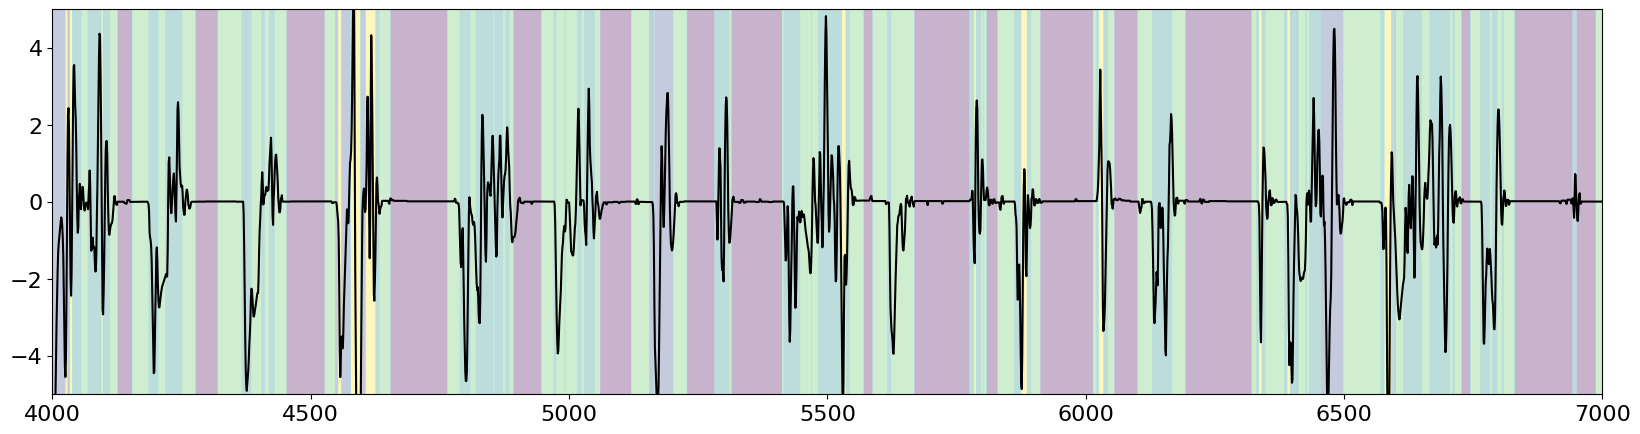

In [58]:
# Plot raw trace over states
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)

# ax.plot(data)
ax.plot(filtered_matrix[:len(data), 0], color='black')
ax.imshow(np.concatenate([y_kmeans])[None,:], 
            extent=(0, len(np.concatenate([y_kmeans])), -5, 5),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
    
init = 4000
ax.set_xlim([init, init+3000])
ax.set_ylim([-5, 5])

plt.show()

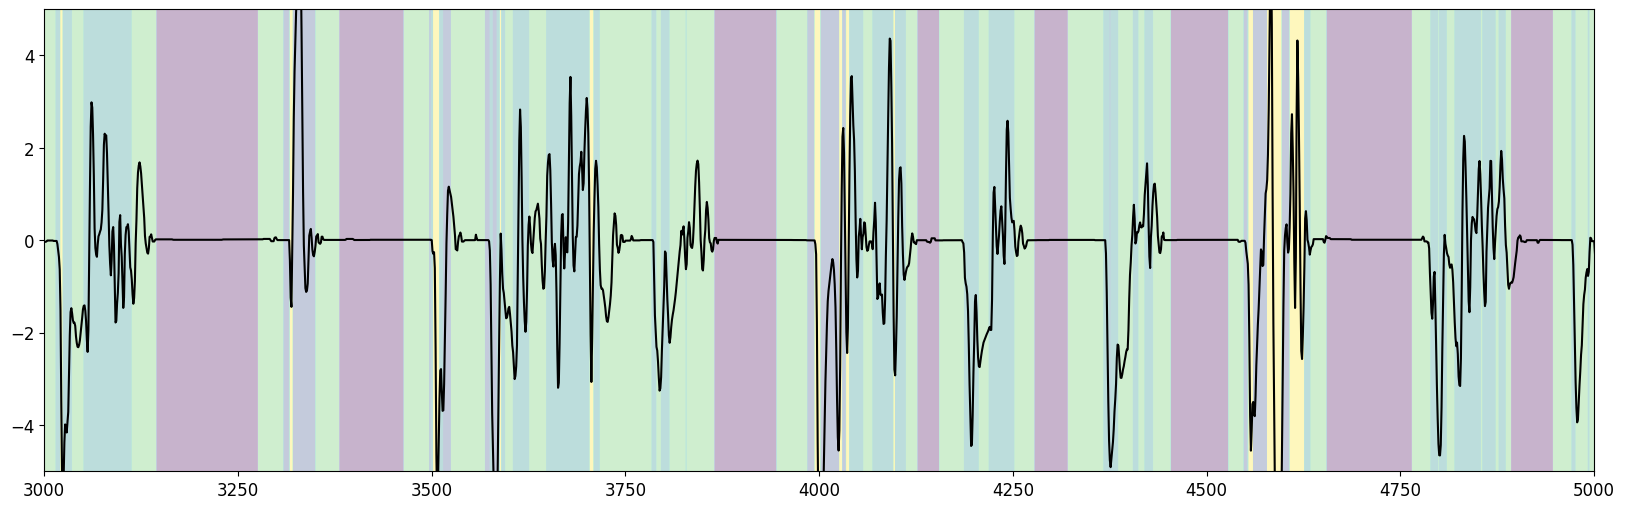

In [59]:
# Plot raw trace over states
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)

# ax.plot(data)
ax.plot(filtered_matrix[:len(data), 0], color='black')
ax.imshow(np.concatenate([y_kmeans])[None,:], 
            extent=(0, len(np.concatenate([y_kmeans])), -5, 5),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
    
init = 3000
ax.set_xlim([init, init+2000])
ax.set_ylim([-5, 5])

plt.show()